In [1]:
using Plots
using Statistics
using Surrogates
using CSV
using DataFrames
using Distributions
using Flux
import JSON
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables

include("../../scan_hyperparameters_withcellnum_functions.jl")

main (generic function with 1 method)

### Loading data and making cuts for proper scaling

In [2]:
target_directory = "../../data/full_with_cellnumber/"

println("Formatting data...")
x_raw_df, y_df, cellnumber_df = getrawdata_withcellnum(target_directory)

# how to process cellnumber, for now let's make it another dvar
x_raw_origcn_df = hcat(x_raw_df, cellnumber_df)
x_raw_df = hcat(x_raw_df, cellnumber_df .% 2)

# cutting
println("Cutting Transmission to 60-100 percent...")
lower::Float32 = 60
upper::Float32 = 120
x_raw_df, y_df = applycut(x_raw_df, y_df, "OBJ1", lower, upper; with_numcells=true)

# decorrelating
println("Decorrelating...")
x_df = decorrelatedvars(x_raw_df; with_numcells=true)

x_scaled_df, x_scalers = minmaxscaledf(x_df);
y_scaled_df, y_scalers = minmaxscaledf(y_df);

println("Done!")

Formatting data...
Cutting Transmission to 60-100 percent...
x_raw shape: (217293, 15)
y_raw shape: (217293, 6)
x_new shape: (161574, 15)
y_new shape: (161574, 6)
Decorrelating...
Done!


A sanity check since Julia alphabetizes column names:

Recall that these are the original ranges of our DVARs

```
DVAR1: Bmax  [ 8.5, 12.0 ]
DVAR2: mX1  [ 5, 140 ]
DVAR3: mX2  [ 15, 160 ]
DVAR4: mY1  [ 1.005, 1.7 ]
DVAR5: mY2  [ 1.055, 1.85 ]
DVAR6: mtau1  [ 1, 500 ]
DVAR7: mtau2  [ 1, 500 ]
DVAR8: PhiY1  [ -89.95, -30 ]
DVAR9: PhiY2  [ -87.45, -25 ]
DVAR10: Phitau1  [ 1, 500 ]
DVAR11: Phitau2  [ 1, 500 ]
DVAR12: mY3ref  [ 1.105, 2.0 ]
DVAR13: PhiY3ref  [ -84.95, -20 ]
DVAR14: Eref  [ 0.055, 0.075 ]
```

but recall also that we decorrelate `DVAR3`, `DVAR5`, `DVAR9`, `DVAR12`, `DVAR13`. This means that their unscaled values will fall between 0 and 1.

In [3]:
x_scalers # looks good

Dict{String, MinMaxScaler} with 15 entries:
  "DVAR7"      => MinMaxScaler(1.00229, 499.997)
  "DVAR5"      => MinMaxScaler(-7.45177f-8, 0.999996)
  "DVAR12"     => MinMaxScaler(7.62605f-6, 0.999995)
  "DVAR14"     => MinMaxScaler(0.0550001, 0.075)
  "DVAR2"      => MinMaxScaler(5.00044, 139.998)
  "DVAR10"     => MinMaxScaler(1.00164, 499.998)
  "DVAR1"      => MinMaxScaler(8.50003, 12.0)
  "DVAR3"      => MinMaxScaler(1.07697f-5, 0.999994)
  "DVAR6"      => MinMaxScaler(1.00127, 499.998)
  "DVAR4"      => MinMaxScaler(1.00501, 1.7)
  "DVAR8"      => MinMaxScaler(-89.95, -30.0006)
  "DVAR13"     => MinMaxScaler(2.18249f-5, 0.999996)
  "cellnumber" => MinMaxScaler(0.0, 1.0)
  "DVAR11"     => MinMaxScaler(1.0075, 499.997)
  "DVAR9"      => MinMaxScaler(3.582f-7, 0.999969)

In [4]:
println(names(x_df))
println(names(x_scaled_df))

["DVAR1", "DVAR2", "DVAR3", "DVAR4", "DVAR5", "DVAR6", "DVAR7", "DVAR8", "DVAR9", "DVAR10", "DVAR11", "DVAR12", "DVAR13", "DVAR14", "cellnumber"]
["DVAR1", "DVAR2", "DVAR3", "DVAR4", "DVAR5", "DVAR6", "DVAR7", "DVAR8", "DVAR9", "DVAR10", "DVAR11", "DVAR12", "DVAR13", "DVAR14", "cellnumber"]


In [5]:
@assert names(x_df) == names(x_scaled_df)

In [6]:
function decorrelate_single(data_to_transform, dynamic_lower_bound, strict_upper_bound; inverse=false)
    if inverse
        dynamic_lower_bound + data_to_transform*(strict_upper_bound - dynamic_lower_bound)
    else
        (data_to_transform - dynamic_lower_bound) / (strict_upper_bound - dynamic_lower_bound)
    end
end

decorrelate_single (generic function with 1 method)

In [81]:
function decorr(vec)
    # we are only decorrelating unscaled vectors, which means that these vectors have their DVARs in
    # quasi-numerical order DVAR1, ... DVAR14, cellnumber
    maxes = Dict(
        "DVAR3"=>160.,
        "DVAR5"=>1.85,
        "DVAR9"=>-25.,
        "DVAR12"=>2.,
        "DVAR13"=>-20.
    )
    etas = Dict(
        "DVAR3"=>10.,
        "DVAR5"=>0.05,
        "DVAR9"=>2.5,
        "DVAR12"=>0.05,
        "DVAR13"=>2.5
    )
    dvarmap = Dict(
        3=>2, # DVAR3prime ∼ Uniform(DVAR2prime + δ3, u3) 
        5=>4,
        9=>8,
        12=>5,
        13=>9
    )
    
    decorred_vec = []
    
    for i in 1:15
        dvar = (i == 15) ? "cellnumber" : "DVAR$i"
        # transform?
        if dvar ∈ keys(maxes)
            dependent_dvar = deps[dvar]
            append!(decorred_vec, getdvarprimesing(vec[i], etas[dvar] + vec[dvarmap[i]], maxes[dvar])) 
        else
            append!(decorred_vec, vec[i])
        end
    end
    decorred_vec
end

function recorr(vec)
    # we are only recorrelating scaled vectors, which means that these vectors have their DVARs in
    # quasi-alphabetical order DVAR1, DVAR10, ... DVAR2, ... DVAR9, cellnumber
    maxes = Dict(
        "DVAR3"=>160.,
        "DVAR5"=>1.85,
        "DVAR9"=>-25.,
        "DVAR12"=>2.,
        "DVAR13"=>-20.
    )
    etas = Dict(
        "DVAR3"=>10.,
        "DVAR5"=>0.05,
        "DVAR9"=>2.5,
        "DVAR12"=>0.05,
        "DVAR13"=>2.5
    )
    dvarmap = Dict(
        3=>2,
        5=>4,
        9=>8,
        12=>5,
        13=>9
    )
    
    recorred_vec = []
    
    for i in 1:14
        if i ∈ [3, 5, 9]
            append!(
                recorred_vec, decorrelate_single(vec[i], etas["DVAR$i"] + vec[dvarmap[i]], maxes["DVAR$i"]; inverse=true)
            )
        elseif i ∈ [12, 13]
            append!(
                recorred_vec,
                decorrelate_single(
                    vec[i], etas["DVAR$i"] + recorred_vec[dvarmap[i]], maxes["DVAR$i"]; inverse=true
                )
            )
        else
            append!(recorred_vec, vec[i])
        end
    end
    
    recorred_vec
end

function minmaxscale(vec; var="x", inverse=false)
    outvec = []
    
    transform_fun(scaler, x) = inverse ? inverse_transform(scaler, x) : transform(scaler, x)
    
    if var == "x"
        for i in 1:14
            scaler = x_scalers["DVAR$i"]
            append!(outvec, transform_fun(scaler, vec[i]))
        end
    elseif var == "y"
        for i in 1:6
            scaler = y_scalers["OBJ$i"]
            append!(outvec, transform_fun(scaler, vec[i]))
        end
    end
    
    return Tuple(outvec)
end

minmaxscale (generic function with 1 method)

### Loading Model

In [10]:
function model_id_to_nn(model_id, x_dim, y_dim)
    model_params = Dict()
    
    for substring in split(model_id, "_")
        if occursin("-", substring)
            continue
        elseif occursin("w=", substring)
            model_params["width"] = parse(Int, last(split(substring, "=")))
        elseif occursin("d=", substring)
            model_params["depth"] = parse(Int, last(split(substring, "=")))
        elseif occursin("activation=", substring)
            activation_function_string = last(split(substring, "="))
            model_params["activation"] = parseactivationfunctions([activation_function_string])[1]
        elseif occursin("dr=", substring)
            model_params["dropout_rate"] = parse(Float32, last(split(substring, "=")))
        end
    end
    
    neuralnetworkwithdropout(
        x_dim, y_dim, model_params["width"], model_params["depth"],
        model_params["dropout_rate"], model_params["activation"]
    )
end

model_id_to_nn (generic function with 1 method)

In [11]:
model_id = "2023-06-09_16-51-56_w=100_d=5_activation=sigmoid_bs=1024_lr=0.001_dr=0.0_1"
model_state = JLD2.load("../../models/$model_id.jld2", "model_state");
m = model_id_to_nn(model_id, size(x_df)[2], size(y_df)[2]);
Flux.loadmodel!(m, model_state);

#@load "../../models/2023-06-08_18-19-09_w=100_d=5_activation=sigmoid_bs=1024_lr=0.001_dr=0.0_1.jld2" m; old way

In [12]:
function predict(x_vec)
    m([x_vec...])'
end

predict (generic function with 1 method)

In [13]:
# do i understand how the model predicts for a given x_vec?
println(values(first(x_scaled_df)))

println("Prediction:")
println(predict(values(first(x_scaled_df))))
println("True:")
println(first(y_scaled_df))

(0.28920162f0, -0.3137467f0, 0.1475414222175786, 0.6688763f0, 0.5534791401182384, -0.7847122f0, -0.8160064f0, -0.45144355f0, 0.3313838669893703, -0.44775814f0, 0.4049338f0, 0.17109923841804942, 0.3576814045090202, -0.43408716f0, -1.0f0)
Prediction:
[0.5578821564812669 -0.43035188954754455 -0.4797973030578322 -0.464684724347858 0.1516217500128258 -0.22247154462093893]
True:
DataFrameRow
 Row │ OBJ1     OBJ2       OBJ3       OBJ4       OBJ5      OBJ6      
     │ Any      Any        Any        Any        Any       Any       
─────┼───────────────────────────────────────────────────────────────
   1 │ 0.56962  -0.495385  -0.494174  -0.463365  0.222158  -0.215965


### Functionality to predict cellnumber

In [14]:
ENV["PYTHON"] = ""                                                                                                                                   
using Pkg
Pkg.build("PyCall")
using PyCall

# Julia uses a Python that is installed to a separte location than my current anaconda3 installation.
# the following lines make sure that the correct Python packages are installed to read in the supplemental
# Python script that computes cell number

# using Conda
# Conda.add("scipy")
# Conda.add("matplotlib")

py"""
import sys
sys.path.insert(0, "./../../compute_cellnumber/")
"""

compute_cellnumber = pyimport("compute_cellnumber")["compute_cellnumber"]

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/e32a90da027ca45d84678b826fffd3110bb3fc90/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/62f417f6ad727987c755549e9cd88c46578da562/build.log`


PyObject <function compute_cellnumber at 0x2071b2290>

In [15]:
# compute_cellnumber function uses different row keys
# this is a nice sanity check to make sure we're passing in the data through the correct slots
dvar_to_param = Dict(
    "DVAR1" => "Bmax",
    "DVAR2" => "mX1",
    "DVAR3" => "mX2",
    "DVAR4" => "mY1",
    "DVAR5" => "mY2",
    "DVAR6" => "mtau1",
    "DVAR7" => "mtau2",
    "DVAR8" => "PhiY1",
    "DVAR9" => "PhiY2",
    "DVAR10" => "Phitau1",
    "DVAR11" => "Phitau2",
    "DVAR12" => "mY3ref",
    "DVAR13" => "PhiY3ref",
    "DVAR14" => "Eref",
)

function jl_row_to_py_row(jl_row)
    pyrow = Dict()
    
    for i in 1:14
        pyrow[dvar_to_param["DVAR$i"]] = jl_row["DVAR$i"]
    end
    
    pyrow
end

jl_row_to_py_row (generic function with 1 method)

In [16]:
values(x_raw_df[10, :])

(11.272526f0, 113.67641f0, 142.83572f0, 1.3236254f0, 1.7508091f0, 26.869146f0, 52.817062f0, -37.27841f0, -34.61879f0, 93.22662f0, 467.92874f0, 1.8544296f0, -29.753065f0, 0.07108371f0, 1)

In [17]:
compute_cellnumber(jl_row_to_py_row(x_raw_df[10, :]))

59

In [18]:
# sanity check
cns_pred = []
cns_true = []

problematic_idx = []

for i in 1:size(x_raw_df)[1]
    
    if y_df[i, "OBJ1"] < 50
        continue
    else

        try
            cn = compute_cellnumber(jl_row_to_py_row(x_raw_df[i, :])) % 2
            append!(cns_pred, cn)
            append!(cns_true, x_raw_df[:, 15][i])
        catch
            append!(problematic_idx, i)
            continue
        end 
    end
end

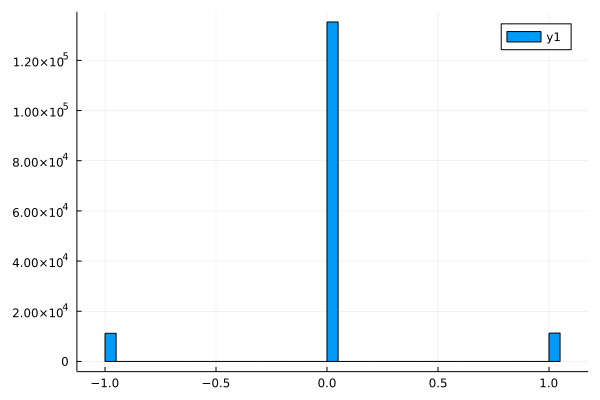

In [19]:
histogram(cns_pred .- cns_true)

### Final optimization
- Maximize transmission (< 95%)
- Output energy should be 70 KeV (0.070 MeV)
- Minimize RFQ length
- Minimize longitudinal emittance
- Minimize transverse emittance

In [20]:
# optimization initialization
# bounds of scaled DVARS
lower_bound = repeat([-1.], 14); upper_bound = repeat([1.], 14)

# smapling to instantiate acquisition function
n_samples = 1000
initial_samples = Surrogates.sample(n_samples, lower_bound, upper_bound, SobolSample());

In [26]:
# how to go from scaled vec to unscaled
recorr(minmaxscale([1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]; var="x", inverse=true))

14-element Vector{Any}:
  11.99997329711914
   5.0004377365112305
  -0.09655507573353359
   1.6999975442886353
  -7.499828372758981
 499.9979407787323
 499.99658024311066
 -30.000564575195312
  11.397639693413401
 499.99833953380585
 499.99743032455444
   0.8941773979463276
   0.38048795357933507
   0.07499995827674866

In [110]:
println(transform(y_scalers["OBJ2"], 0.060)[1])

-0.6430769752750756


In [129]:
function objective3(x_vec)
    x_vec_unscaled = recorr(minmaxscale(x_vec; var="x", inverse=true))
    x_vec_unscaled_dict = Dict("DVAR$i" => x_vec_unscaled[i] for i in 1:14)
    local cellnumber
    try
        cellnumber = compute_cellnumber(jl_row_to_py_row(x_vec_unscaled_dict))
    catch
        cellnumber = 0
    end
    y = predict((x_vec..., cellnumber % 2))
    target_energy_scaled = transform(y_scalers["OBJ2"], 0.065)[1]
    [-y[1], (y[2] - target_energy_scaled)^2, y[3], y[4], y[5], y[6]]
end

objective3 (generic function with 1 method)

In [130]:
x3s = [sample for sample in initial_samples];
x3s = unique(x3s)
y3s = objective3.(x3s);

In [131]:
if length(x3s) != length(unique(x3s))
    print("Duplicate entries in x3")
end
if length(x3s) != length(y3s)
    print("Dimension mismatch between x3 and y")
end
radial_basis_ego_3 = RadialBasis(x3s, y3s, repeat([-1.], 14), repeat([1.], 14))

(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{NTuple{14, Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Float64, Bool}) (generic function with 1 method)

In [132]:
pareto_set_3, pareto_front_3 = surrogate_optimize(
    objective3, SMB(), repeat([-1.], 14), repeat([1.], 14), radial_basis_ego_3, SobolSample();
    maxiters = 100, n_new_look = 100
);

In [133]:
obj1_3 = [inverse_transform(y_scalers["OBJ1"], -item[1])[1] for item in pareto_front_3];
dE_3 = [item[2] for item in pareto_front_3];
obj3_3 = [inverse_transform(y_scalers["OBJ3"], item[3])[1] for item in pareto_front_3];
obj4_3 = [inverse_transform(y_scalers["OBJ4"], item[4])[1] for item in pareto_front_3];
obj5_3 = [inverse_transform(y_scalers["OBJ5"], item[5])[1] for item in pareto_front_3];
obj6_3 = [inverse_transform(y_scalers["OBJ6"], item[6])[1] for item in pareto_front_3];

unscaled_pareto_front_3 = [obj1_3, dE_3, obj3_3, obj4_3, obj5_3, obj6_3];

In [134]:
emit_cutoff = 0.04
long_emit_mask = obj4_3 .< emit_cutoff; trans_emit_mask = obj5_3 .< emit_cutoff;


transmission_cutoff = 90
high_transmission_mask = obj1_3 .> 90

sum(long_emit_mask .& trans_emit_mask .& high_transmission_mask)

6

In [135]:
candidates = [i for i in 1:length(obj1_3)][long_emit_mask .& trans_emit_mask .& high_transmission_mask]

6-element Vector{Int64}:
 171
 254
 288
 348
 398
 438

In [136]:
#= test_x_transformed = minmaxscale(
    decorr([
        11.312972997315228, 103.74379149079323, 149.3844627470438,
        1.4468421232886612, 1.5137411917386079, 140.85678020119667,
        473.1951289474964, -50.19836366921663, -43.642034931217914,
        245.1396713256836, 245.14222234487534, 1.8956206666091737,
        -37.693693497970166, 0.06037112592457561,
    ]);
    var="x"
)

println(predict((test_x_transformed..., 0.)))
println(predict((test_x_transformed..., 1.))) =#

In [137]:
for j in candidates
    println("candidate $j")
    # println(pareto_set_3[j])
    candidate_dvars = minmaxscale(pareto_set_3[j]; var="x", inverse=true)
    println(recorr(candidate_dvars))
    #= for i in 1:6
        # println("OBJ$i: ", unscaled_pareto_front_3[i][j])
    end =#
    cellnumber = compute_cellnumber(jl_row_to_py_row(Dict("DVAR$i" => recorr(candidate_dvars)[i] for i in 1:14)))
    println(minmaxscale(predict([pareto_set_3[j]..., cellnumber % 2]); var="y", inverse=true))
    println(" ")
end

candidate 171
Any[10.062017227523029, 137.2295216023922, 148.96312277608195, 1.155000753235072, 1.5419863910777163, 106.74567946791649, 339.6751715838909, -75.8407868668437, -48.74626530450168, 133.0603334903717, 382.55937081575394, 1.9223008957411605, -21.30725489444107, 0.07189450521400431]
(90.96425792504166, 0.07731638669786571, 183.97191291524527, 0.03946798262662321, 0.02419984580787612, 0.03195639023883736)
 
candidate 254
Any[10.118412774521858, 84.29833798110485, 131.41601322559444, 1.0772895046975464, 1.8291771210962868, 363.797188565135, 78.72649578750134, -86.11531944945455, -40.485142641954155, 324.3261600136757, 407.16776087880135, 1.9404736150175776, -21.48415692092073, 0.0725487987838278]
(96.99984313887114, 0.07817390041467057, 152.84750882658642, 0.03897777583568955, 0.027873957233091343, 0.02710740161526323)
 
candidate 288
Any[9.749278285074979, 79.55232898890972, 125.22350334605127, 1.107152342563495, 1.4213671605778617, 400.83209793269634, 330.1728388518095, -78.3

In [61]:
function plot_pairwise_scatter(vec1, vec2, vec1label, vec2label, indexes, winner_index, incl_xticks, incl_yticks)
    loser_indexes = [i for i in indexes if i != winner_index]
    
    
    scatter(
        [vec1[i] for i in loser_indexes], [vec2[i] for i in loser_indexes];
        xlabel=vec1label, ylabel=vec2label, legend=false, markersize=3, markerstrokewidth=0.5,
        xformatter = incl_xticks ? :auto : Returns(""), yformatter = incl_yticks ? :auto : Returns("") 
    )
    
    scatter!([vec1[winner_index]], [vec2[winner_index]]; markershape=:star5, markersize=10, markerstrokewidth=0.5)
end

plot_pairwise_scatter (generic function with 1 method)

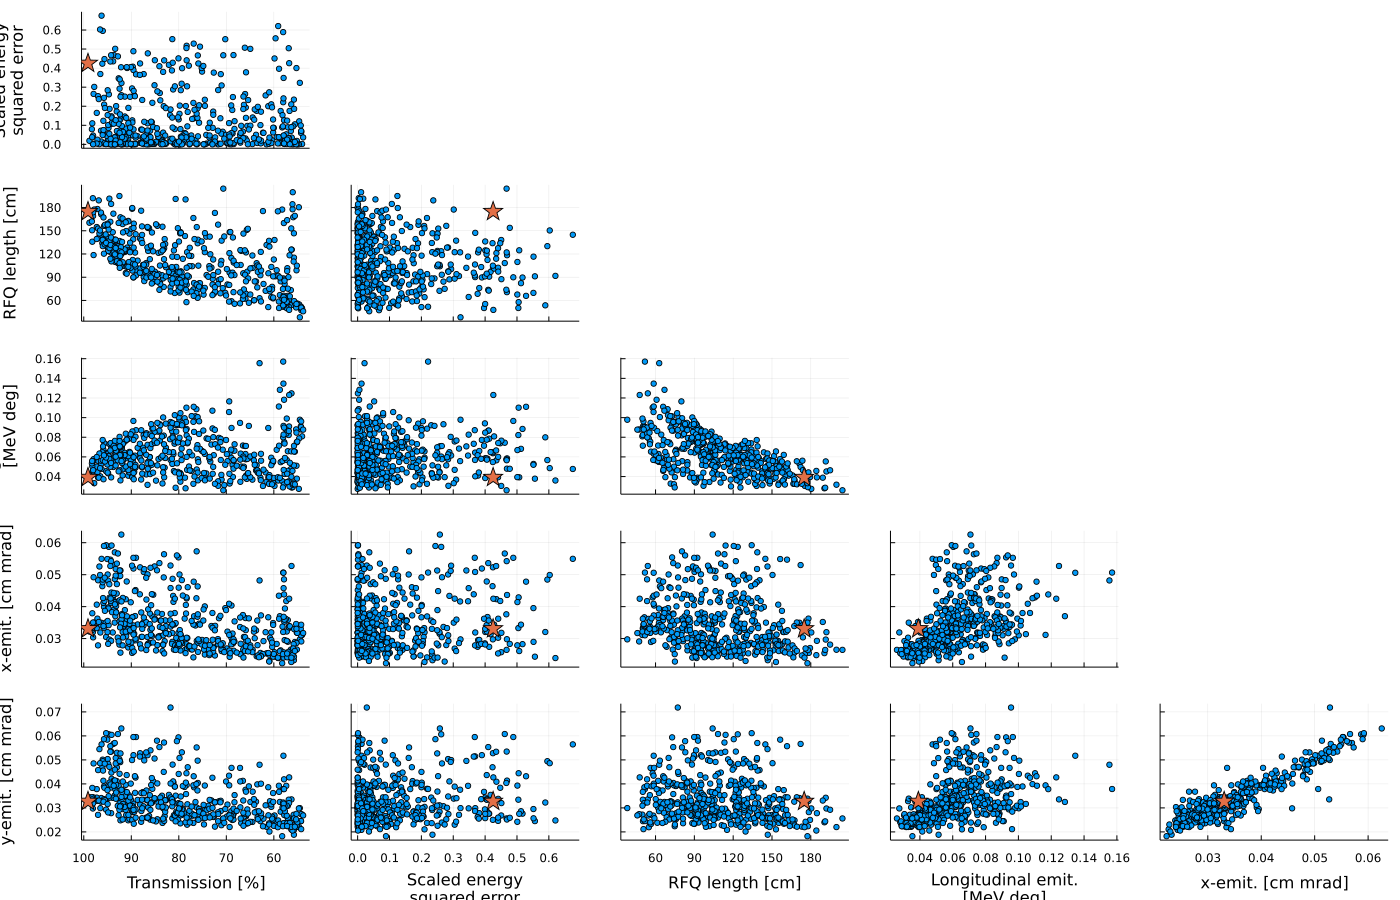

In [79]:
winner_index = 451

labels = [
    "Transmission [%]",
    "Scaled energy\nsquared error",
    "RFQ length [cm]",
    "Longitudinal emit.\n[MeV deg]",
    "x-emit. [cm mrad]",
    "y-emit. [cm mrad]"
]
indexes = [i for i in 1:length(pareto_front_3)]

layout = @layout([ ° _ _ _ _ ; ° ° _ _ _ ; ° ° ° _ _ ; ° ° ° ° _ ; ° ° ° ° ° ])

#plot(p1, p2, p3, layout = l)

plots_dict = Dict()

for i in 1:(length(labels) - 1)
    for j in 1:length(labels)
        if i < j
            p = plot_pairwise_scatter(
                unscaled_pareto_front_3[i], unscaled_pareto_front_3[j],
                j==length(labels) ? labels[i] : "", i==1 ? labels[j] : "", indexes, winner_index,
                j==length(labels), i==1
            )
            if i == 1
                xflip!(true)
            end
            # display(p)
            merge!(plots_dict, Dict("$i$j"=>p))
        end
    end
end

pareto_plot = plot(
    [plots_dict["$i$j"] for j in 1:length(labels) for i in 1:length(labels) if i<j]...,
    layout = layout, widths=(1/4,1/4,1/4,1/4), size=(1400,900), dpi=500
)

# savefig(pareto_plot,"../../img/pareto_plot.png")

In [78]:
length(labels)

6

## CHECKING OPTIMAL ANSWER FROM ABOVE

In [39]:
optimal_dvars = [
    9.14601474441588,
    64.9847204387188,
    76.2309561819387,
    1.5052128004608676,
    1.7909850165139312,
    159.3742377460003,
    287.0468702018261,
    -49.37874272093177,
    -44.20807974211494,
    446.882483959198,
    415.69541972875595,
    1.9007708828235987,
    -38.63379833969139,
    0.07181640870840056,
]

optimal_dvars_decorr = decorr(optimal_dvars);
optimal_dvars_decorred_scaled = minmaxscale(optimal_dvars_decorr);
optimal_predicted_objs_scaled = predict(optimal_dvars_decorred_scaled..., compute_cellnumber);
optimal_predicted_objs = minmaxscale(optimal_predicted_objs_scaled; var="y", inverse=true)

LoadError: UndefVarError: deps not defined